<a href="https://colab.research.google.com/github/stoianmihail/HyperTone/blob/main/HyperTone_Preprocessing-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import json
import os

DB_EPS = 1e-6
EPS = 1e-9

In [2]:
def get_files(path):
  ret = []
  for root, _, files in os.walk(path, topdown=False):
    for file in files:
      ret.append({'path': os.path.join(root,file), 'data' : None})
  return ret

In [3]:
hypertone_dir = '/content/drive/MyDrive/hypertone/'
preprocessing_dir = hypertone_dir + 'preprocessing/'
model_dir = hypertone_dir + 'model/'
model_file = hypertone_dir + 'model/model.h5'
input_directory = '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie'
tones = {tone : {'dir' : input_directory + '/utrenia-glas' + str(tone) + '-macarie/Inregistrari', 'files' : None} for tone in list(range(1, 8 + 1))}

In [4]:
tones

{1: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari',
  'files': None},
 2: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari',
  'files': None},
 3: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari',
  'files': None},
 4: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari',
  'files': None},
 5: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari',
  'files': None},
 6: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari',
  'files': None},
 7: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari',
  'files': None},
 8: {'

In [5]:
for tone in tones.keys():
  tones[tone]['files'] = get_files(tones[tone]['dir'])
tones[1]['files']

[{'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1. 9 Ceea ce eşti mai cinstită.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.2 Troparele.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1. 15 Preabinecuvântată eşti.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.6 Antifoanele.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.7 Prochimenul.m4a'},
 {'data': None,
  'path': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.12 Stihira 2 Laude.m4a'},
 {'data': 

In [6]:
kTones = 8
kBinsPerOctave = 24

# Corresponds to a jump from Pa -> Ga
kJump = int(4/3 * kBinsPerOctave)

fmin = librosa.midi_to_hz(36) # C2 (Ison)
fmax = librosa.midi_to_hz(84) # C6 (highest note ever seen in byzantine sheets: A5#)
print(fmin)
print(fmax)

65.40639132514966
1046.5022612023945


In [48]:
filename=tones[1]['files'][0]['path']
print(filename)
ipd.Audio(filename)

/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari/1.2 Troparele.m4a


In [7]:
import math

def find_bin(f):
# Find which bin `f` fits into.
# The bins are geometrically distributed.
# Formula: 2**(i/`kBinsPerOctave`) * fmin
# Source: https://en.wikipedia.org/wiki/Constant-Q_transform
  return int(round(math.log2(f / fmin) * kBinsPerOctave)) if not math.isnan(f) else f

In [50]:
y, sr = librosa.load(filename)
print(sr)
f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=fmin, fmax=fmax)
print(f0)
times = librosa.times_like(f0)
print(times)
pyin_bins = list(map(find_bin, f0))
print(len(pyin_bins))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


22050
[nan nan nan ... nan nan nan]
[0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 1.35650975e+02
 1.35674195e+02 1.35697415e+02]
5845


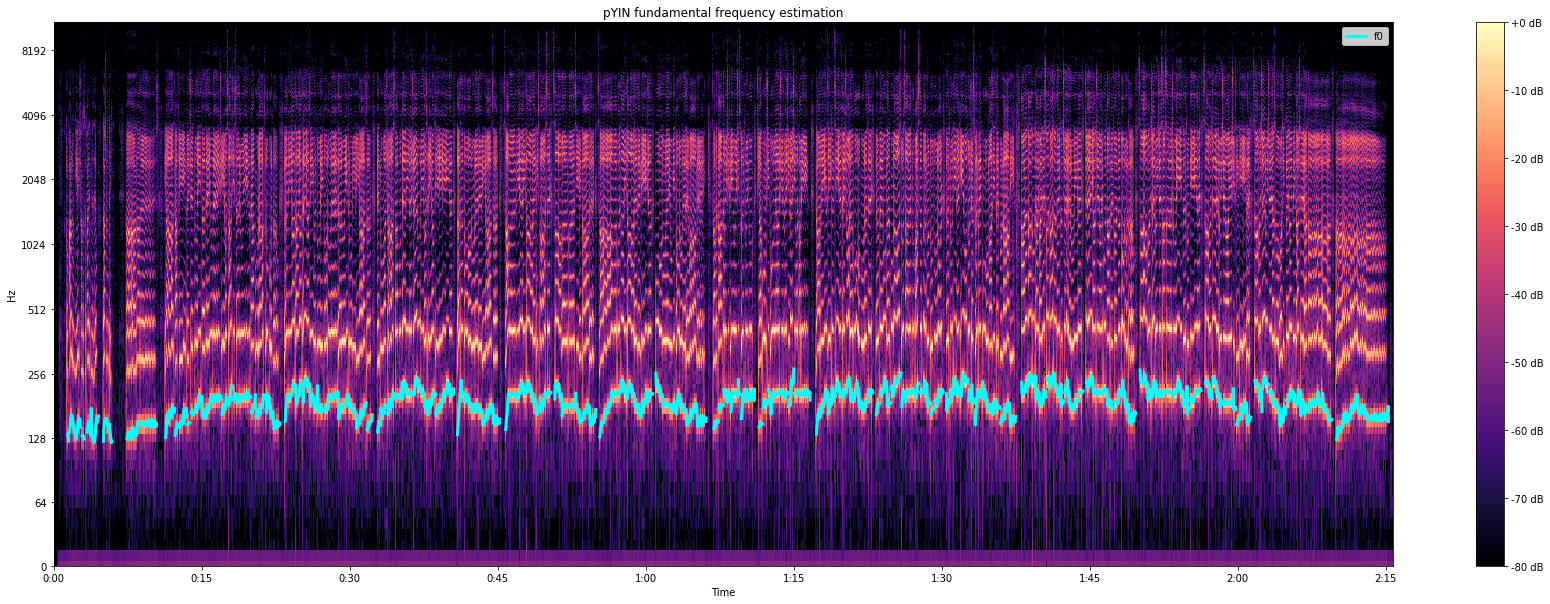

In [51]:
import matplotlib.pyplot as plt
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots(figsize=(30, 10))
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

[0.02321995 0.02321995 0.02321995 ... 0.02321995 0.02321995 0.02321995]
len(y)=2992128
sr=22050
num_seconds=135.69741496598638
43.07377558714066
window_length=15
5845


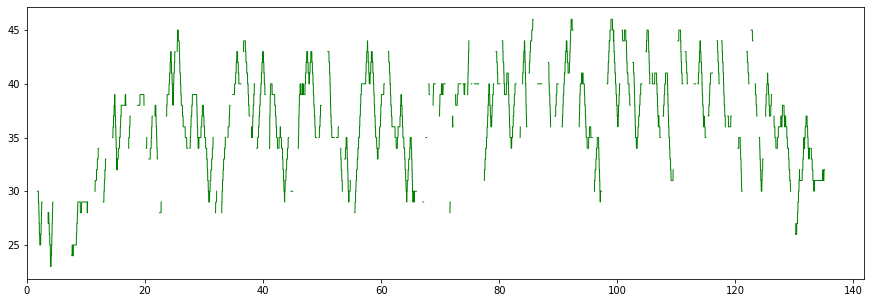

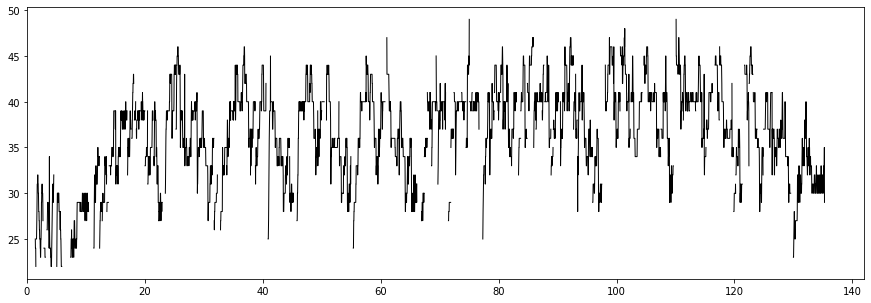

In [76]:
C3_ = librosa.midi_to_hz(36) # C2 (Ison)
D3 = librosa.midi_to_hz(84) # C6 (highest note ever seen in byzantine sheets: A5#)

print(np.diff(times))

from scipy.signal import savgol_filter
num_seconds = len(y) / sr

print(f"len(y)={len(y)}")
print(f"sr={sr}")
print(f"num_seconds={num_seconds}")
samples_per_second = (len(times) / num_seconds)
print(samples_per_second)

# 1 sec ... 16 notes
# x sec ... 1 note
# 1 note = 1/16 sec
# 1 sec ... 43 samples
# 16 notes .. 43 samples
# 1 noe ... 43/16 samples

window_length = int(samples_per_second / 3)
if window_length % 2 == 0:
  window_length += 1
print(f"window_length={window_length}")
yhat = savgol_filter(f0, window_length, 1)
print(len(yhat))

tmp_pyin_bins = list(map(find_bin, yhat))


plt.figure(figsize=(kPlotWidth, kPlotWidth / 3))
plt.plot(times,tmp_pyin_bins, color='green', linewidth=1.0)
plt.xlim(xmin=0)
plt.show()

plt.figure(figsize=(kPlotWidth, kPlotWidth / 3))
plt.plot(times, pyin_bins, color='black', linewidth=1.0)
#plt.plot(times,yhat, color='green', linewidth=2.0)
plt.xlim(xmin=0)
plt.show()

In [8]:
def normalize_diffs(bins):
  pitch_diff = []
  last_index_non_nan = None
  for index, elem in enumerate(bins):
    # First position?
    if index == 0:
      continue
    # NaN?
    if math.isnan(elem):
      continue
    # No prev elem which is not NaN?
    if last_index_non_nan is None:
      last_index_non_nan = index
      continue
    diff = bins[index] - bins[last_index_non_nan]

    if abs(diff) > kJump:
      last_index_non_nan = index
      continue

    # isPositive = diff > 0
    # while abs(diff) > kJump and diff < 0:
    #   # `bins[last_index_non_nan]` >= `elem`.
    #   bins[index] += kBinsPerOctave
    #   diff = bins[index] - bins[last_index_non_nan]
      
    # while abs(diff) > kJump and diff > 0:
    #   # `bins[last_index_non_nan]` <= `elem`.
    #   pyin_bins[last_index_non_nan] += kBinsPerOctave
    #   diff = bins[index] - bins[last_index_non_nan]
    
    # Update
    last_index_non_nan = index
    pitch_diff.append(diff)
  return pitch_diff

In [11]:
from scipy.signal import savgol_filter

def solve_audio(filepath_, tone_):
  y_, sr_ = librosa.load(filepath_)
  f0_, voiced_flag_, voiced_probs_ = librosa.pyin(y_, fmin=fmin, fmax=fmax)

  # Number of seconds
  num_seconds_ = len(y_) / sr_

  # How many pyin samples / second
  samples_per_second_ = (len(f0_) / num_seconds_)
  
  # Compute the window length
  window_length_ = int(samples_per_second_ / 3)
  if window_length_ % 2 == 0:
    window_length_ += 1

  print(f"samples_per_second={samples_per_second_}, window_length={window_length_}")

  # Filter
  num_skips_ = int(samples_per_second_ * 5)
  yhat_ = savgol_filter(f0_[num_skips_:], window_length_, 1)

  # And determine the bins
  filtered_bins_ = list(map(find_bin, yhat_))
  return [filtered_bins_, normalize_diffs(filtered_bins_), tone_]

In [80]:
ret = solve_audio(filename, 0)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


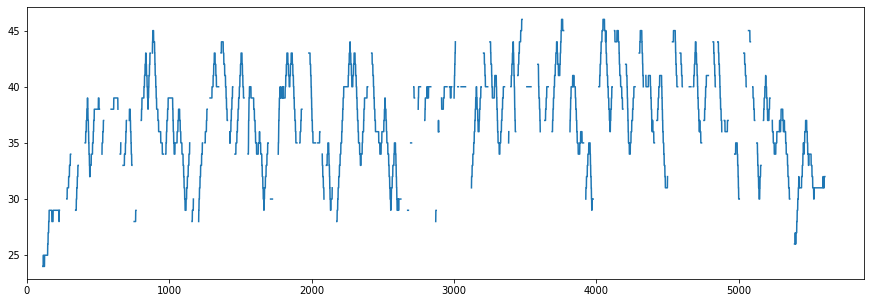

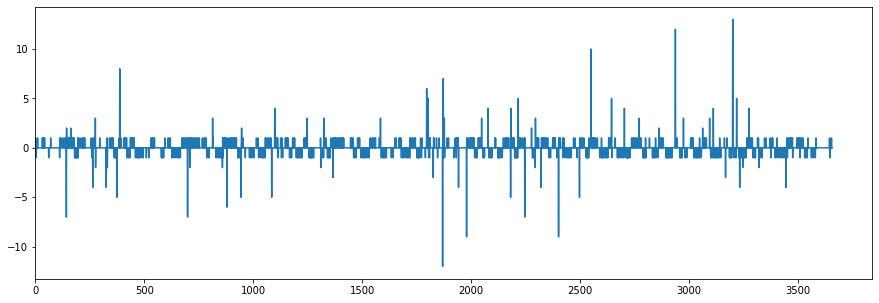

In [81]:
kPlotWidth = 15
plt.figure(figsize=(kPlotWidth, kPlotWidth / 3))
plt.plot(ret[0])
plt.xlim(xmin=0)
plt.show()

plt.figure(figsize=(kPlotWidth, kPlotWidth / 3))
plt.plot(ret[1])
plt.xlim(xmin=0)
plt.show()

In [ ]:
import os
import pickle

def prepare_data():
  print('Save tones..')
  acc = []
  for tone in tones:
    print('Tone: ' + str(tone))
    for index, file in enumerate(tones[tone]['files']):
      audio_name = os.path.basename(file['path']).replace('.m4a', '')
      print(f"Progress {1 + index} out of {len(tones[tone]['files'])}: Preprocessing {audio_name}")
      with open(preprocessing_dir + audio_name + '.pkl', 'wb') as f:
        pickle.dump(solve_audio(file['path'], tone), f)
  pass

prepare_data()

Save tones..
Tone: 1
Progress 1 out of 15: Preprocessing 1. 9 Ceea ce eşti mai cinstită


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.09087579900568, window_length=15
Progress 2 out of 15: Preprocessing 1.2 Troparele


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.07377558714066, window_length=15
Progress 3 out of 15: Preprocessing 1. 15 Preabinecuvântată eşti


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.08198180379747, window_length=15
Progress 4 out of 15: Preprocessing 1.6 Antifoanele


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.07103306631392, window_length=15
Progress 5 out of 15: Preprocessing 1.7 Prochimenul


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.08427612811203, window_length=15
Progress 6 out of 15: Preprocessing 1.12 Stihira 2 Laude


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.083856171495135, window_length=15
Progress 7 out of 15: Preprocessing 1.14 Stihira 4 Laude


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.07482258891929, window_length=15
Progress 8 out of 15: Preprocessing 1.1 Dumnezeu este D


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.10602575896964, window_length=15
Progress 9 out of 15: Preprocessing 1.4 Al doilea rând de sed


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.072384374132426, window_length=15
Progress 10 out of 15: Preprocessing 1.11 Stihira 1 Laude


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.08689454983349, window_length=15
Progress 11 out of 15: Preprocessing 1.10 Toată suflarea


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.07509775479314, window_length=15
Progress 12 out of 15: Preprocessing 1.3 Primul rând de sed


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.07222131970699, window_length=15
Progress 13 out of 15: Preprocessing 1.13 Stihira 3 Laude


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.080975399610956, window_length=15
Progress 14 out of 15: Preprocessing 1.8 Toată suflare ante Ev


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.0919346473029, window_length=15
Progress 15 out of 15: Preprocessing 1.5 Ipacoiul


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.096863397277225, window_length=15
Tone: 2
Progress 1 out of 15: Preprocessing 2. 15 Preabinecuvântată eşti


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.08100998219735, window_length=15
Progress 2 out of 15: Preprocessing 2.2 Troparele


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.07488388902559, window_length=15
Progress 3 out of 15: Preprocessing 2.9 Ceea ce eşti mai cinstită


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.08988847805343, window_length=15
Progress 4 out of 15: Preprocessing 2.7 Prochimenul


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.085328221111595, window_length=15
Progress 5 out of 15: Preprocessing 2.3 Primul rând de sed


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.073310130450466, window_length=15
Progress 6 out of 15: Preprocessing 2.6 Antifoanele


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.07075947007986, window_length=15
Progress 7 out of 15: Preprocessing 2.5 Ipacoiul


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.08897774174528, window_length=15
Progress 8 out of 15: Preprocessing 2.13 Stihira 3 Laude


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.076684628579955, window_length=15
Progress 9 out of 15: Preprocessing 2.12 Stihira 2 Laude


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.07528226118096, window_length=15
Progress 10 out of 15: Preprocessing 2.11 Stihira 1 Laude


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.07914402173913, window_length=15
Progress 11 out of 15: Preprocessing 2.1 Dumnezeu este D


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.10281065088758, window_length=15
Progress 12 out of 15: Preprocessing 2.10 Toată suflarea


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.07632938508065, window_length=15
Progress 13 out of 15: Preprocessing 2.8 Toată suflarea ante Ev


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.09003017004937, window_length=15
Progress 14 out of 15: Preprocessing 2.14 Stihira 4 Laude


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.07367116333502, window_length=15
Progress 15 out of 15: Preprocessing 2.4 Al doilea rând de sed


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.07366015032845, window_length=15
Tone: 3
Progress 1 out of 15: Preprocessing 3.13 Stihira 3 Laude


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.08119046086508, window_length=15
Progress 2 out of 15: Preprocessing 3.11 Stihira 1 Laude


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.08235086542022, window_length=15
Progress 3 out of 15: Preprocessing 3.10 Toată suflarea


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.07392613933997, window_length=15
Progress 4 out of 15: Preprocessing 3.9 Ceea ce eşti mai cinstită


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.09110029028096, window_length=15
Progress 5 out of 15: Preprocessing 3.14 Stihira 4 Laude


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.0832950367647, window_length=15
Progress 6 out of 15: Preprocessing 3. 15 Preabinecuvântată eşti


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.08113484310875, window_length=15
Progress 7 out of 15: Preprocessing 3.7 Prochimenul


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.090345330739304, window_length=15
Progress 8 out of 15: Preprocessing 3.3 Primul rând de sed


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


samples_per_second=43.072598400431346, window_length=15
Progress 9 out of 15: Preprocessing 3.4 Al doilea rând de sed


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
import pickle
import pandas as pd

def compress(a):
  return a[np.logical_or(np.insert(np.diff(a).astype(bool), 0, True), np.asarray(a, dtype=bool))]

def parse_songs():
  songs = {}
  for file in get_files(preprocessing_dir):
    if '.pkl' not in file['path']:
      continue 
    song_name = os.path.basename(file['path']).replace('.pkl', '')
    x = pd.read_pickle(file['path'])
    compressed = compress(np.asarray(x[1]))
    
    # TODO: this is only for these recordings
    # TODO: Next time, also save the label!
    tone = 5
    if song_name[0].isdigit():
      tone = int(song_name[0])
    if tone == 1 or tone == 8:# or tone == 5 or tone == 3:
      songs[song_name] = {'x': compressed, 'y': tone}
  return songs

songs = parse_songs()
print(songs['8.2 Troparele'])

{'x': array([-1,  1,  0, -1,  0,  1, -1,  0,  2, -1, -1, -1,  0,  4, -5,  1, -2,
        0,  1,  0, -1,  0, -1,  0,  4,  1,  1,  1,  0, -1,  0, -1,  0, -1,
        1,  0, -6,  2,  1,  1,  1,  0,  1,  0, -1,  0, -1,  0,  1,  0, -1,
        0, -7,  4,  1,  1,  1,  0,  1, -1,  0, -1, -1, -1,  0,  1,  1,  0,
       -1, -1,  0,  1,  1,  1,  0,  1, -1, -1, -1,  0, -1,  0,  1,  0,  2,
        1,  1,  0, -1,  0,  1,  0, -1,  0,  1,  0, -1,  0, -1,  0,  1,  0,
        1,  0, -1,  0,  1,  1,  0, -1,  0, -1,  0,  1,  1,  0, -1,  0, -1,
        0,  1,  0,  1,  2, -6,  1,  3,  0,  2,  1,  1,  1,  1,  0,  1,  0,
        1,  0,  1,  0, -1,  0,  1,  0, -1,  0,  1,  0, -1,  1,  0,  1,  0,
       -9,  2,  0,  1,  0,  1,  0, -1,  0,  1,  0,  5, -2,  0,  1, -1,  0,
       -1,  3, -2,  8, -4,  0,  1,  1,  1,  0, -1, -1,  0, -1,  0,  1,  0,
       -1,  0, -2,  2, -5, -1,  2,  2,  1,  0, -1, -2,  0,  1,  0,  1, -1,
        0, -2, -5,  0,  1,  1,  0,  2,  1,  0,  2,  0, -1,  1,  0, -1, -1,
        0, -2,  0, 

In [ ]:
import tensorflow.keras as keras

# TODO: check the best one!
kSequenceLength = 128
kOutputUnits = 2 * kBinsPerOctave - 1
kNumUnits = [kSequenceLength, kSequenceLength // 2]
#kLoss = "categorical_crossentropy"
kLoss = "binary_crossentropy"
kLearningRate = 0.001
kEpochs = 5
kBatchSize = 64

In [ ]:
def update(y):
  if y == 1:
    return 0
  return 1
  # if y == 5:
  #   return 1
  # if y == 3:
  #   return 2
  # return 3

def generate_training_sequences(seq_len):
  """Create input and output data samples for training. Each sample is a sequence.

  :param sequence_length (int): Length of each sequence. With a quantisation at 16th notes, 64 notes equates to 4 bars

  :return inputs (ndarray): Training inputs
  :return targets (ndarray): Training targets
  """

  # load songs and map them to int
  songs = parse_songs()

  inputs, targets = [], []
  for song in songs:
    x = songs[song]['x']
    y = songs[song]['y']
    y = update(y)
    #x[np.insert(np.diff(x).astype(np.bool), 0, True)]
    if len(x) < seq_len:
      x.resize(seq_len)
    num_sequences = len(x) - seq_len + 1
    for index in range(num_sequences):
      inputs.append(x[index : index + seq_len])
      targets.append(y)

  # one-hot encode the sequences  
  # inputs size: (# of sequences, sequence length, max(diff))
  inputs = keras.utils.to_categorical(inputs, num_classes=kOutputUnits)
  print(inputs.shape)
  #n = len(inputs)
  #inputs = np.reshape(inputs, (n, seq_len, 1))
  # normalize input
  #inputs = inputs / float(kOutputUnits)
  
  targets = keras.utils.to_categorical(targets, num_classes=2)
  print(targets.shape)
  print(f"There are {len(inputs)} sequences.")
  return inputs, targets

In [ ]:
# tmp_songs = parse_songs()
# save = None
# for song in tmp_songs:
#   curr = songs[song]['x']
#   save = curr[0 : kSequenceLength]
#   break
# tmp1, tmp2 = generate_training_sequences(kSequenceLength)
# mapping = {}
# for index in range(len(save)):
#   mapping[save[index]] = tmp1[0][index]

# print(mapping)
# #print(f"{save[index]} vs {tmp1[0][index]}")

# print(save)
# print(tmp1[0])
# print(tmp2[0])

In [ ]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

def build_model(shape, output_units, num_units, loss, learning_rate):
    """Builds and compiles model

    :param output_units (int): Num output units
    :param num_units (list of int): Num of units in hidden layers
    :param loss (str): Type of loss function to use
    :param learning_rate (float): Learning rate to apply

    :return model (tf model): The model
    """

    # create the model architecture
    #input = keras.layers.Input(shape=(None, output_units))
    #x = keras.layers.LSTM(num_units[0])(input)
    #x = keras.layers.LSTM(num_units[1])(x)
    #x = keras.layers.Dropout(0.2)(x)
    #output = keras.layers.Dense(kTones, activation="softmax")(x)
    #model = keras.Model(input, output)

    # compile model
    #model.compile(loss=loss,
    #              optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    #              metrics=["accuracy"])

    print(shape)

    model = Sequential()
    # model.add(LSTM(
    #     num_units[0],
    #     input_shape=(shape[1], shape[2]),
    #     recurrent_dropout=0.3,
    #     return_sequences=False
    # ))
    model.add(LSTM(num_units[0], input_shape=(shape[1], shape[2])))
    #model.add(LSTM(num_units[1], recurrent_dropout=0.3))
    model.add(Dense(2))
    model.add(Activation('sigmoid'))
    model.compile(loss=kLoss, optimizer='adam', metrics=["accuracy"])

    model.summary()
    return model

def train(output_units=kOutputUnits, num_units=kNumUnits, loss=kLoss, learning_rate=kLearningRate):
    """Train and save TF model.

    :param output_units (int): Num output units
    :param num_units (list of int): Num of units in hidden layers
    :param loss (str): Type of loss function to use
    :param learning_rate (float): Learning rate to apply
    """

    # generate the training sequences
    inputs, targets = generate_training_sequences(kSequenceLength)

    print(targets)

    # build the network
    model = build_model(inputs.shape, output_units, num_units, loss, learning_rate)

    filepath = model_dir + "all-weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
    checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )
    callbacks_list = [checkpoint]

    # train the model
    seed = 61
    #X_train, X_val, y_train, y_val = train_test_split(inputs, targets, test_size=0.2, random_state=seed)
    history = model.fit(inputs, targets, epochs=kEpochs, batch_size=kBatchSize, callbacks=callbacks_list)
  
    from matplotlib import pyplot
    print(history.history.keys())
    pyplot.plot(history.history['accuracy'])
    pyplot.plot(history.history['val_accuracy'])
    pyplot.title('model train vs validation loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper right')
    pyplot.show()

    # save the model
    model.save(model_file)

(19920, 128, 47)
(19920, 2)
There are 19920 sequences.
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
(19920, 128, 47)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128)               90112     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_5 (Activation)    (None, 2)                 0         
Total params: 90,370
Trainable params: 90,370
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
312/312 [==============================] - 11s 29ms/step - loss: 0.6937 - accuracy: 0.4942
Epoch 2/5
312/312 [==============================] - 9s 28ms/step - loss: 0.6934 - accuracy: 0.4998
Epoch 3/5
312/312 [============================

KeyError: ignored

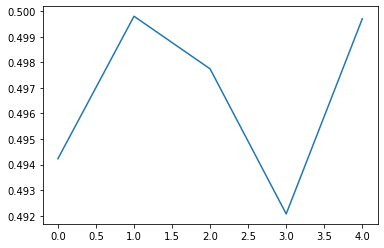

In [ ]:
train()

In [ ]:
class HyperTone:
  """A class that wraps the LSTM model and offers utilities to generate melodies."""

  def __init__(self, path=model_file):
    """Constructor that initialises TensorFlow model"""
    self.model = keras.models.load_model(path)
  
  def extract_tones(self, x):
    # Pad, if necessary
    if len(x) < kSequenceLength:
      x.resize(kSequenceLength)

    y = []
    num_sequences = len(x) - kSequenceLength + 1
    print("num_sequences=" + str(num_sequences))
    for index in range(num_sequences):
      seed = x[index : index + kSequenceLength]

      #print(seed)

      # one-hot encode the seed
      onehot_seed = keras.utils.to_categorical(seed, num_classes=kOutputUnits)

      # (1, max_sequence_length, num of symbols in the vocabulary)
      onehot_seed = onehot_seed[np.newaxis, ...]


      #print(onehot_seed)

      # make a prediction
      probabilities = self.model.predict(onehot_seed)[0]
      #print(probabilities)
      index = self.sample(probabilities)
      y.append(1 + index)              
    return y

  def sample(self, probabilites, temperature=0.1):
    """Samples an index from a probability array reapplying softmax using temperature

    :param predictions (nd.array): Array containing probabilities for each of the possible outputs.
    :param temperature (float): Float in interval [0, 1]. Numbers closer to 0 make the model more deterministic.
        A number closer to 1 makes the generation more unpredictable.

    :return index (int): Selected output symbol
    """
    predictions = np.log(probabilites) / temperature
    probabilites = np.exp(predictions) / np.sum(np.exp(predictions))

    choices = range(len(probabilites)) # [0, 1, 2, 3]
    index = np.random.choice(choices, p=probabilites)

    return index

In [ ]:
f10 = tones[1]['files'][0]['path']
f11 = tones[1]['files'][2]['path']
f80 = tones[8]['files'][1]['path']
f81 = tones[8]['files'][4]['path']

In [ ]:
ipd.Audio(f11)

In [ ]:
ipd.Audio(f81)

In [ ]:
ht = HyperTone('/content/drive/MyDrive/hypertone/model/all-weights-improvement-05-0.0617-bigger.hdf5')
print(ht.extract_tones(encode_audio(f10)))
print(ht.extract_tones(encode_audio(f11)))
print(ht.extract_tones(encode_audio(f81)))
print(ht.extract_tones(encode_audio(f81)))

In [ ]:
test_filename = '/content/drive/MyDrive/hypertone/Utrenia_glas_1_Anastasimatar_Victor_Ojog/Anastasimatar Victor Ojog - Glasul I -  073 Dumnezeu este Domnul paralaghie.mp3'
ht = HyperTone('/content/drive/MyDrive/hypertone/model/all-weights-improvement-05-0.0617-bigger.hdf5')
print(ht.extract_tones(encode_audio(test_filename)))